In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [2]:
%%time

df = pd.read_csv('data/examples.csv')
df.shape

CPU times: user 29.3 s, sys: 3.38 s, total: 32.7 s
Wall time: 34.4 s


(17937758, 9)

While attempting to train the model, it turned out that the reading and unpickling operation done at this scale, with so many files, is very computationally expensive.

But the examples in the mfcc represenatations are very small. Let's read them all into the memory before training.

In [3]:
# uniq_fns = np.unique(df.target_fn.values)

In [4]:
# %%time

# fn2feature = {}
# for fn in uniq_fns:
#     ary = pd.read_pickle(f'data/examples/{fn}.pkl')
#     fn2feature[fn] = ary

# pd.to_pickle(fn2feature, 'data/fn2feature.pkl')

In [5]:
%%time
fn2features = pd.read_pickle('data/fn2feature.pkl')

CPU times: user 19.4 s, sys: 16.6 s, total: 36 s
Wall time: 2min


In [6]:
vocab = list(df.source_word.unique())

In [7]:
# from collections import Counter
# counter = Counter(df.source_word)

# most_common_words = set([t[0] for t in counter.most_common(1000)])

I suspect that reading the data from a file saved within numpy (`numpy.save`) is much less computationally expensive than unpickling it, but I might be wrong. Either way, at ~4 million of unique utterances, the dataset is small enough to comfortably fit within memory of a GCP instance (at ~53GBs used RAM during training).

This might not be ideal for experimentation on home rigs. Saving the data using `numpy.save` and evaluating performance would definitely be a very interesting and useful exercise.

In [8]:
df.head()

,source_word,target_word,source_fn,target_fn,set_name,speaker_id,book_id,distance_from_target,audio_fpath
0,I,FELT,8af4aebcf4a74004b02db9f88d99e89a,1cb9442ec1a6468282da309756e2ff57,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
1,I,THAT,8af4aebcf4a74004b02db9f88d99e89a,2f60546c930c47068ee0a129e6d51c39,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
2,FELT,I,1cb9442ec1a6468282da309756e2ff57,8af4aebcf4a74004b02db9f88d99e89a,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
3,FELT,THAT,1cb9442ec1a6468282da309756e2ff57,2f60546c930c47068ee0a129e6d51c39,train-clean-360,7000,83696,1,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac
4,FELT,IT,1cb9442ec1a6468282da309756e2ff57,155ad336d88c4cbf814a1237983b5b18,train-clean-360,7000,83696,2,data/LibriSpeech/train-clean-360/7000/83696/7000-83696-0000.flac


In [9]:
train_examples = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])]
valid_examples = df[df.set_name == 'test-clean']

In [10]:
train_examples.size, valid_examples.size

(159688530, 1751292)

In [11]:
%%time

unique_fns = df.source_fn.unique()
np.random.shuffle(unique_fns)
lengths = []
for i, features in enumerate(fn2features.values()):
    lengths.append(features.shape[0])

CPU times: user 5.59 s, sys: 208 ms, total: 5.8 s
Wall time: 5.8 s


In [12]:
max(lengths)

291

In [13]:
np.mean(lengths)

29.028019713968394

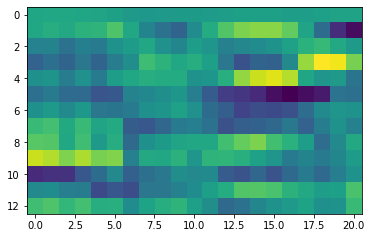

In [14]:
plt.imshow(features.T)

In [15]:
dataset_mean = -5
dataset_std = 15

def normalize_data(ary):
    return (ary - dataset_mean) / dataset_std

In [64]:
def empty_list():
    return list()

In [16]:
# %%time

# word2row_idxs = defaultdict(empty_list)

# for idx, row in df.iterrows():
#     word2row_idxs[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs, 'data/word2row_idxs.pkl')

In [336]:
word2row_idxs = pd.read_pickle('data/word2row_idxs.pkl')

In [433]:
def prepare_features(fn, pad_to=40, pad_left=False):
    ary = fn2features[fn][:pad_to]
    example = np.zeros((pad_to, 13))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [415]:
if np.nan in vocab: vocab.remove(np.nan)

In [416]:
# from torch.utils.data import Dataset

In [558]:
class Dataset():
    def __init__(self, n):
        self.vocab = vocab * n
    def __len__(self):
        return len(self.vocab)
    def __getitem__(self, idx):
        row_idx = np.random.randint(len(word2row_idxs[self.vocab[idx]]))
        source_fn = df.source_fn[row_idx]
        target_fn = df.target_fn[row_idx]
        x = normalize_data(prepare_features(source_fn, pad_left=True))
        y = normalize_data(prepare_features(target_fn))
        return np.stack((x, y)), y

In [411]:
# dss = Datasets(
#     vocab*100,
#     [lambda word: normalize_data(prepare_features(word, df.source_fn, pad_left=True)),
#      lambda word: normalize_data(prepare_features(word, df.target_fn)),
#      lambda word: normalize_data(prepare_features(word, df.target_fn))],
#     n_inp=2,
#     splits = [np.arange(len(vocab)*90), np.arange(len(vocab)*90, len(vocab)*100)]
# )

In [340]:
# BS = 2048
# LR = 1e-3
# NUM_WORKERS = 8

# train_dl = DataLoader(dss.train, BS, NUM_WORKERS, shuffle=True)
# valid_dl = DataLoader(dss.valid, BS, NUM_WORKERS)

# dls = DataLoaders(train_dl, valid_dl)

In [524]:
# from torch.utils.data import DataLoader as TorchLoader

In [559]:
BS = 2048
LR = 1e-3
NUM_WORKERS = 8

train_dl = DataLoader(Dataset(100), BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(Dataset(10), BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [560]:
for batch in dls.train:
    break

In [561]:
batch[0].shape

torch.Size([2048, 2, 40, 13])

In [536]:
# tdl = TorchLoader(Dataset(100), BS, num_workers=NUM_WORKERS, shuffle=True)

In [493]:
# Got the following error while training:

# DataLoader worker (pid 2073) is killed by signal: Bus error. It is possible that dataloader's workers are out of shared memory. Please try to raise your shared memory limit.
# trying the solution I found here: https://github.com/pytorch/pytorch/issues/5040
# which is to execute
!sudo umount /dev/shm/ && sudo mount -t tmpfs -o rw,nosuid,nodev,noexec,relatime,size=50G shm /dev/shm

umount: /dev/shm/: target is busy
        (In some cases useful info about processes that
         use the device is found by lsof(8) or fuser(1).)


In [481]:
# # unidirectional encoder
# teacher_forcing_ratio = 0

# class Model(Module):
#     def __init__(self, hidden_size=50, hint_n=1):
#         self.hint_n = hint_n
#         self.encoder= nn.LSTM(
#             input_size=13,
#             hidden_size=hidden_size,
#             num_layers=1,
#             batch_first=True,
#             dropout=0,
#             bidirectional=False
#         )
#         self.decoder = nn.LSTM(
#             input_size=hidden_size+13,
#             hidden_size=hidden_size,
#             num_layers=1,
#             batch_first=True,
#             dropout=0,
#             bidirectional=False
#         )
#         self.lin = nn.Linear(hidden_size, 13)
            
#     def forward(self, source_features, target_features):
#         _, (embeddings_dec, _) = self.encoder(source_features)

#         outputs = torch.zeros_like(target_features)
#         outputs[:, :self.hint_n, :] = target_features[:, :self.hint_n, :]
        
#         hidden = embeddings_dec
#         embeddings_dec = embeddings_dec.squeeze(0)
#         cell = torch.zeros_like(embeddings_dec).unsqueeze(0)
        
#         for t in range(self.hint_n):
#             input = torch.cat((outputs[:, t:t+1, :], embeddings_dec.unsqueeze(1)), 2)
#             x, (hidden, cell) = self.decoder(input, (hidden, cell))
#             x = self.lin(x)
#             input = (torch.sigmoid(x) - 0.5) * 16
        
#         for t in range(self.hint_n, target_features.shape[1]):
#             input = torch.cat((input, embeddings_dec.unsqueeze(1)), 2)
#             x, (hidden, cell) = self.decoder(input, (hidden, cell))
#             x = self.lin(x)
#             input = (torch.sigmoid(x) - 0.5) * 16
#             outputs[:, t, :] = input.squeeze()
            
#             if random.random() < teacher_forcing_ratio:
#                 input = target_features[:, t, :].unsqueeze(1)
#         return outputs

In [343]:
# for batch in train_dl:
#     break

# model = Model(hint_n=5).cuda()
# o = model(batch[0].cuda(), batch[1].cuda())
# plt.imshow(o[0][:5, :].detach().cpu())

# plt.imshow(batch[1][0][:5, :].detach().cpu())

In [660]:
# teacher_forcing_ratio = 0

class Model(Module):
    def __init__(self, hidden_size=50):
        self.encoder= nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.decoder = nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.lin = nn.Linear(hidden_size, 13)
            
    def forward(self, source_and_target_features):
        source_features = source_and_target_features[:, 0]
        target_features = source_and_target_features[:, 1]
        _, (embeddings, cell) = self.encoder(source_features)
        input = torch.cat(
            (
                target_features[:, :-1, :],
                embeddings.permute(1, 0, 2).repeat(1, target_features.shape[1]-1, 1)
            ), 2)
#         cell = torch.zeros_like(embeddings)
        x, _ = self.decoder(target_features[:, :-1, :], (embeddings, cell))
        return self.lin(x)

In [661]:
# mse_loss = MSELoss()
# def modified_MSE(preds, targs):
#     mask = targs == 0
#     preds[mask] = 0
#     return mse_loss(preds, targs)

# mse_loss = MSELoss()
def targ_trunc_MSE(preds, targs):
    return mse_loss(preds, targs[:, 1:, :])

learn = Learner(dls.cuda(), Model().cuda(), loss_func=targ_trunc_MSE, lr=1e-3, opt_func=Adam)

In [ ]:
learn.fit(1, cbs=SaveModelCallback(fname='1e-3_SGD', every_epoch=True), lr=1e-3)

epoch,train_loss,valid_loss,time


In [656]:
learn.fit(1, cbs=SaveModelCallback(fname='1e-3_SGD', every_epoch=True), lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.015654,0.015553,03:34


In [653]:
%debug

> /opt/conda/lib/python3.7/site-packages/torch/nn/functional.py(1676)linear()
   1674         ret = torch.addmm(bias, input, weight.t())
   1675     else:
-> 1676         output = input.matmul(weight.t())
   1677         if bias is not None:
   1678             output += bias

ipdb> output.shape
*** NameError: name 'output' is not defined
ipdb> u
> /opt/conda/lib/python3.7/site-packages/torch/nn/modules/linear.py(91)forward()
     89 
     90     def forward(self, input: Tensor) -> Tensor:
---> 91         return F.linear(input, self.weight, self.bias)
     92 
     93     def extra_repr(self) -> str:

ipdb> u
> /opt/conda/lib/python3.7/site-packages/torch/nn/modules/module.py(722)_call_impl()
    720             result = self._slow_forward(*input, **kwargs)
    721         else:
--> 722             result = self.forward(*input, **kwargs)
    723         for hook in itertools.chain(
    724                 _global_forward_hooks.values(),

ipdb> u
> <ipython-input-650-fc10a01056d0>(34)fo

In [569]:
for batch in train_dl:
    break

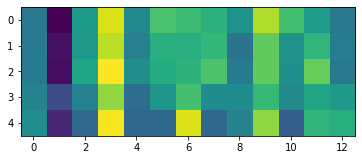

In [571]:
o = learn.model(batch[0].cuda())
plt.imshow(o[0][:5, :].detach().cpu())

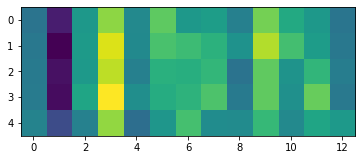

In [572]:
plt.imshow(batch[1][0][:5, :].detach().cpu())

## Calculate embedding for each unique word in the dataset

In [584]:
df_unique_utterances = df.drop_duplicates(['source_fn'])
df_unique_utterances.reset_index(drop=True, inplace=True)

In [595]:
class DatasetAllUtterances():
    def __len__(self):
        return df_unique_utterances.shape[0]
    def __getitem__(self, idx):
        source_fn = df_unique_utterances.iloc[0].source_fn
        target_fn = df_unique_utterances.iloc[0].target_fn
        x = normalize_data(prepare_features(source_fn, pad_left=True))
        y = normalize_data(prepare_features(target_fn))
        return np.stack((x, y)), y

In [596]:
all_dl = DataLoader(DatasetAllUtterances(), BS, NUM_WORKERS)

In [637]:
%%time

all_embeddings = []
with torch.no_grad():
    learn.model.train = False
    for batch in all_dl:
        _, (embeddings, _) = learn.model.encoder(batch[0][:, 0].cuda())
        all_embeddings.append(embeddings.view(embeddings.shape[1], -1).detach().cpu())

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f022ed43050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f022ed43050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f022ed43050>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 138, in join
   

CPU times: user 7min 55s, sys: 24.9 s, total: 8min 20s
Wall time: 6min 6s


In [638]:
all_embeddings = torch.cat(all_embeddings)

In [611]:
with torch.no_grad():
    for batch in all_dl:
        outputs = learn.model(batch[0].cuda())
        break

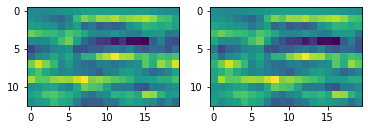

In [612]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[-1].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][-1].cpu().numpy().T[:, :20])

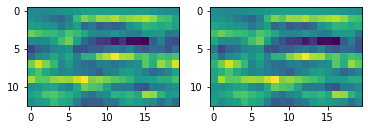

In [613]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[-10].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][-10].cpu().numpy().T[:, :20])

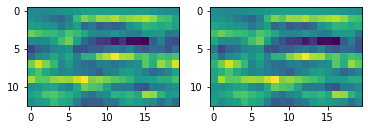

In [614]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(outputs[0].cpu().numpy().T[:, :20])
axs[1].imshow(batch[1][0].cpu().numpy().T[:, :20])

In [ ]:
# %%time

# word2row_idxs_unique_utterances = defaultdict(empty_list)

# for idx, row in df_unique_utterances.iterrows():
#     word2row_idxs_unique_utterances[row.source_word].append(idx)
    
# pd.to_pickle(word2row_idxs_unique_utterances, 'word2row_idxs_unique_utterances.pkl')

In [639]:
word2row_idxs_unique_utterances = pd.read_pickle('word2row_idxs_unique_utterances.pkl')

In [640]:
word2embedding = {}

for k, v in word2row_idxs_unique_utterances.items():
    word2embedding[k] = all_embeddings[np.array(v)].mean(0)

In [641]:
word2embedding_without_nans= {}
nans_encountered = 0
for k, v in word2embedding.items():
    if k in vocab and k == k and (not np.isnan(v.numpy()).any()):
        word2embedding_without_nans[k] = v.numpy()
    else: nans_encountered += 1

print(f'Encountered rows with nan values: {nans_encountered}')

Encountered rows with nan values: 1


## Evaluating embeddings using [word-embeddings-benchmarks](https://github.com/kudkudak/word-embeddings-benchmarks)

In [642]:
import logging
from six import iteritems
from web.datasets.similarity import fetch_MEN, fetch_WS353, fetch_SimLex999
from web.embeddings import fetch_GloVe
from web.evaluate import evaluate_similarity
from web.embedding import Embedding, Vocabulary
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [643]:
tasks = {
    "MEN": fetch_MEN(),
    "WS353": fetch_WS353(),
    "SIMLEX999": fetch_SimLex999()
}

In [644]:
our_embeddings = Embedding(
    Vocabulary([w.lower() for w in list(word2embedding_without_nans.keys())]),
    np.array(list(word2embedding_without_nans.values()))
)

speech2vec = KeyedVectors.load_word2vec_format('../speech2vec-pretrained-vectors/speech2vec/50.vec', binary=False) 
speech2vec_embeddings = Embedding(Vocabulary(list(speech2vec.vocab.keys())), speech2vec.vectors)

In [645]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(speech2vec_embeddings, data.X, data.y)))

Missing 392 words. Will replace them with mean vector
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:336: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  A = np.vstack(w.get(word, mean_vector) for word in X[:, 0])
/opt/conda/lib/python3.7/site-packages/web-0.0.1-py3.7.egg/web/evaluate.py:337: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  B = np.vstack(w.get(word, mean_vector) for word in X[:, 1])
Missing 61 words. Will replace them with mean vector
Missing 24 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.5896756323911225
Spearman correlation of scores on WS353 0.49890235673392536
Spearman correlation of scores on SIMLEX999 0.28202624769092116


In [646]:
for name, data in iteritems(tasks):
    print("Spearman correlation of scores on {} {}".format(name, evaluate_similarity(our_embeddings, data.X, data.y)))

Missing 242 words. Will replace them with mean vector
Missing 49 words. Will replace them with mean vector
Missing 11 words. Will replace them with mean vector


Spearman correlation of scores on MEN 0.016336071418511844
Spearman correlation of scores on WS353 -0.019580171882017928
Spearman correlation of scores on SIMLEX999 -0.022798757099223497


In [ ]:
### from IPython.lib.display import Audio

# row = df.sample(1)
# print(row.target_word)
# Audio(f'data/examples_audio/{row.target_fn.item()}.wav')